# *BehavePro Analysis notebook*
---
Generates analytics for entire folders of data

In [1]:
#import everything and set dpi here

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 #set dpi for viewing figs within the notebook
import scipy.stats as stats

### Load the infotable

In [2]:
#directory = r"C:/Users/njana/Desktop/Behavior/MeAeffStim Results/May1523_MeAeffStim_simbaResults/" # include / at end
directory = r"C:/Users/njana/Desktop/Behavior/Esr1ChronosStim/Day 1/" # include / at end

infofile = directory+"deets.csv"
infotable = pd.read_csv(infofile)
archive_name = "Aug2323_DualStim"

infotable

,name,type,BlindID,MouseID,Type,Day,Trial,stimdur,Total,startf,endf,trunc end,ethofile
0,Tr1n01,standard,NaN,FW,Chronos,1,2,30,38040,0,38040,0,Hardware-Nov1323_EsrStimD1-Trial 2-Arena 1
1,Tr2n02,standard,NaN,FW,Chronos,1,4,30,37822,0,37822,0,Hardware-Nov1323_EsrStimD1-Trial 4-Arena 1
2,Tr3n03,standard,NaN,FW,Chronos,1,5,30,37876,871,37876,0,Hardware-Nov1323_EsrStimD1-Trial 5-Arena 1
3,Tr4n04,standard,NaN,FW,Chronos,1,6,30,38971,794,38971,0,Hardware-Nov1323_EsrStimD1-Trial 6-Arena 1
4,Tr5n05,standard,NaN,FW,Chronos,1,7,30,37885,773,37885,0,Hardware-Nov1323_EsrStimD1-Trial 7-Arena 1


### Archive data into ```hdf5``` for unblinding

In [13]:
''' archive data '''

behav_data = []
stim_data = []

for i in range(infotable.shape[0]):
    #get the data
    simbarawdata = pd.read_csv(directory+infotable.name[i]+".csv", header = 0)

    behavdata = simbarawdata[["Probability_Aggression","Aggression",	
                            "Probability_Mounting",	"Mounting", 
                            "Probability_Following",	"Following",	
                            "Probability_Dominate",	"Dominate",	
                            "Probability_Social_Contact",	"Social_Contact",	
                            "Probability_Asocial",	"Asocial",	
                            "Probability_Passive",	"Passive",	
                            "Probability_Rest_Move",	"Rest_Move"]]
    
    ethoexportpath = directory+infotable.ethofile[i]+".txt"
    ethoexport = pd.read_csv(ethoexportpath, sep = ';', header = 37)#, encoding='UTF-16le') # so stupid that this works but it does #if issue with UTF-8, use 16le

    input1 = ethoexport.loc[ethoexport["Name"] == "Is input 1 High"]
    input1high = input1.loc[input1["Value"] == 1]
    input1 = input1.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input1high = input1high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])

    input2 = ethoexport.loc[ethoexport["Name"] == "Is input 2 High"]
    input2high = input2.loc[input2["Value"] == 1]
    input2 = input2.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input2high = input2high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    
    stimtimes = input2high["Recording time"].to_numpy()
    stimtimes = np.asarray(stimtimes, dtype=float)

    truncated = infotable.startf[i]
    fps = 30
    timetrunc = truncated/fps
    stimtimes = stimtimes - timetrunc
    
    stimstartidx = np.around(stimtimes*fps).astype("int")

    stimdur = infotable.stimdur[i] #in seconds
    stimidxdur = stimdur*fps
    stimendidx = stimstartidx + stimidxdur

    stim = np.zeros(behavdata[behavdata.columns[0]].shape[0])

    for j in range(stimstartidx.shape[0]):
        stim[stimstartidx[j]:stimendidx[j]] = 1
        
    behav_data += [behavdata]
    stim_data += [stim]

archive = infotable
archive['behavior_traces'] = behav_data
archive['stimulus_traces'] = stim_data

archive.to_hdf(directory+archive_name+"_Blind_archive.h5", 'data' ,complevel = 0)

C:\Users\njana\AppData\Local\Temp\ipykernel_436\1054319239.py:58: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['name', 'type', 'BlindID', 'MouseID', 'Type', 'ethofile',
       'behavior_traces', 'stimulus_traces'],
      dtype='object')]

  archive.to_hdf(directory+archive_name+"_Blind_archive.h5", 'data' ,complevel = 0)


### Plot behavior traces with averages

In [6]:
''' Plot with Averages''' 

# for i in range(1):
for i in range(infotable.shape[0]):
    #get the data
    simbarawdata = pd.read_csv(directory+infotable.name[i]+".csv", header = 0)

    behavdata = simbarawdata[["Probability_Aggression","Aggression",	
                            "Probability_Mounting",	"Mounting", 
                            "Probability_Following",	"Following",	
                            "Probability_Dominate",	"Dominate",	
                            "Probability_Social_contact",	"Social_contact",	
                            "Probability_Asocial",	"Asocial",	
                            "Probability_Passive",	"Passive",	
                            "Probability_Rest_move",	"Rest_move"]]
    
    ethoexportpath = directory+infotable.ethofile[i]+".txt"
    ethoexport = pd.read_csv(ethoexportpath, sep = ';', header = 37)#, encoding='UTF-16le') # so stupid that this works but it does #if issue with UTF-8, use 16le

    input1 = ethoexport.loc[ethoexport["Name"] == "Is input 1 High"]
    input1high = input1.loc[input1["Value"] == 1]
    input1 = input1.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input1high = input1high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])

    input2 = ethoexport.loc[ethoexport["Name"] == "Is input 2 High"]
    input2high = input2.loc[input2["Value"] == 1]
    input2 = input2.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input2high = input2high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    
    stimtimes = input2high["Recording time"].to_numpy()
    stimtimes = np.asarray(stimtimes, dtype=float)

    truncated = infotable.startf[i]
    fps = 30
    timetrunc = truncated/fps
    stimtimes = stimtimes - timetrunc
    
    stimstartidx = np.around(stimtimes*fps).astype("int")

    stimdur = infotable.stimdur[i] #in seconds
    stimidxdur = stimdur*fps
    stimendidx = stimstartidx + stimidxdur

    stim = np.zeros(behavdata[behavdata.columns[0]].shape[0])

    for j in range(stimstartidx.shape[0]):
        stim[stimstartidx[j]:stimendidx[j]] = 1
    
    BlindID = str(infotable.BlindID[i])
    MouseID = str(infotable.MouseID[i])
    Type = str(infotable.Type[i])        
    day = str(infotable.Day[i])
    trial = str(infotable.Trial[i])
    time = np.arange(0,behavdata[behavdata.columns[0]].shape[0])/fps
    avgtime = np.arange(0,stimdur*3*fps)/fps

    
    colors = ["red","brown","orange","purple","green","turquoise","black","sandybrown"]
    sns.set_style("white")

    #plt.subplots(9,2,gridspec_kw={'width_ratios': [time.shape[0],stimdur*fps*3]})
    plt.subplots(9,2,gridspec_kw={'width_ratios': [5,1]}) #15,1
    #plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)


    plt.subplot(9,2,1)
    plt.plot(time,stim, color = 'blue')
    plt.ylabel("Stimulus", color = 'blue')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])
    
    plt.subplot(9,2,2)
    plt.plot(avgtime,stim[stimstartidx[0]-(stimdur*fps):stimstartidx[0]+(stimdur*fps*2)], color = 'blue')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])
    
    counter = 0
    plotnum = 3

    for k in range(8):
        
        plt.subplot(9,2,plotnum)
        plt.plot(time,behavdata[behavdata.columns[counter]],  color = colors[k], alpha = 0.3)
        counter += 1
        
        plt.plot(time,behavdata[behavdata.columns[counter]], color = colors[k], alpha = 1)
        plt.ylabel(behavdata.columns[counter], color = colors[k])
        if plotnum < 17:
            plt.gca().set_xticks([])
        else:
            plt.gca().set_xticks(np.arange(min(time), max(time)+1, 300))
        plt.gca().set_yticks([])
        sns.despine(bottom = True, left = True)
        plotnum += 1
        
        plt.subplot(9,2,plotnum)
        
        # calculate the average data
        behav = behavdata[behavdata.columns[counter]].to_numpy()
        window_behav = []
        for ele in stimstartidx:
            window_behav += [behav[ele-(stimdur*fps):ele+(stimdur*fps*2)]]
    
        window_behav = np.array(window_behav)
        avg_behav = np.average(window_behav, axis = 0)
    
        # plot the average data
        plt.plot(avgtime,avg_behav, color = colors[k], alpha = 1)
        plt.ylim(bottom = 0)
        if plotnum < 17:
            plt.gca().set_xticks([])
        else:
            plt.gca().set_xticks([0,30,60,90])
        #plt.gca().set_yticks([])
        sns.despine(bottom = True, left = True)        
            
        counter += 1   
        plotnum += 1
    
    plt.gcf().set_size_inches(16,8)
    
    if MouseID == 'BLIND':
        plt.gcf().suptitle("Resident "+BlindID+": Day "+day+" Trial "+trial, ha = 'left', x = 0.15, y = 0.92, fontsize = 16, fontweight = "bold")
        plt.savefig(directory+BlindID+"_D"+day+"Tr"+trial+".svg", dpi = 600)
        plt.savefig(directory+BlindID+"_D"+day+"Tr"+trial+".png", dpi = 600)
        plt.clf()
        
    else:
        plt.gcf().suptitle(Type+" Resident "+MouseID+" : Day "+day+" Trial "+trial, ha = 'left', x = 0.15, y = 0.92, fontsize = 16, fontweight = "bold")
        plt.savefig(directory+Type+"_"+MouseID+"_"+BlindID+"D"+day+"Tr"+trial+".svg", dpi = 600)
        plt.savefig(directory+Type+"_"+MouseID+"_"+BlindID+"D"+day+"Tr"+trial+".png", dpi = 600)
        plt.clf()        

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

#### Button pressing with averaged fake stims

In [15]:
''' Button Pressing with fake stims averaged''' 

# for i in range(1):
for i in range(infotable.shape[0]):
    #get the data
    simbarawdata = pd.read_csv(directory+infotable.name[i]+".csv", header = 0)

    behavdata = simbarawdata[["Probability_Aggression","Aggression",	
                            "Probability_Mounting",	"Mounting", 
                            "Probability_Following",	"Following",	
                            "Probability_Dominate",	"Dominate",	
                            "Probability_Social_contact",	"Social_contact",	
                            "Probability_Asocial",	"Asocial",	
                            "Probability_Passive",	"Passive",	
                            "Probability_Rest_move",	"Rest_move"]]
    
    ethoexportpath = directory+infotable.ethofile[i]+".txt"
    ethoexport = pd.read_csv(ethoexportpath, sep = ';', header = 37)#, encoding='UTF-16le') # so stupid that this works but it does #if issue with UTF-8, use 16le

    input1 = ethoexport.loc[ethoexport["Name"] == "Is input 1 High"]
    input1high = input1.loc[input1["Value"] == 1]
    input1 = input1.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input1high = input1high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])

    input2 = ethoexport.loc[ethoexport["Name"] == "Is input 2 High"]
    input2high = input2.loc[input2["Value"] == 1]
    input2 = input2.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input2high = input2high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    
    stimtimes = input2high["Recording time"].to_numpy()
    stimtimes = np.asarray(stimtimes, dtype=float)

    fakestimtimes = input1high["Recording time"].to_numpy()
    fakestimtimes = np.asarray(fakestimtimes, dtype=float)

    truncated = infotable.startf[i]
    fps = 30
    timetrunc = truncated/fps
    stimtimes = stimtimes - timetrunc
    fakestimtimes = fakestimtimes - timetrunc
    
    stimstartidx = np.around(stimtimes*fps).astype("int")
    fakestimstartidx = np.around(fakestimtimes*fps).astype("int")
    

    stimdur = infotable.stimdur[i] #in seconds
    stimidxdur = stimdur*fps
    stimendidx = stimstartidx + stimidxdur
    fakestimendidx = fakestimstartidx + stimidxdur

    stim = np.zeros(behavdata[behavdata.columns[0]].shape[0])
    fakestim = np.zeros(behavdata[behavdata.columns[0]].shape[0])

    for j in range(stimstartidx.shape[0]):
        stim[stimstartidx[j]:stimendidx[j]] = 1

    for j in range(fakestimstartidx.shape[0]):
        fakestim[fakestimstartidx[j]:fakestimendidx[j]] = 1
        
    BlindID = str(infotable.BlindID[i])
    MouseID = str(infotable.MouseID[i])
    Type = str(infotable.Type[i])        
    day = str(infotable.Day[i])
    trial = str(infotable.Trial[i])
    time = np.arange(0,behavdata[behavdata.columns[0]].shape[0])/fps
    avgtime = np.arange(0,stimdur*3*fps)/fps

    
    colors = ["red","brown","orange","purple","green","turquoise","black","sandybrown"]
    sns.set_style("white")

    #plt.subplots(9,2,gridspec_kw={'width_ratios': [time.shape[0],stimdur*fps*3]})
    plt.subplots(9,3,gridspec_kw={'width_ratios': [6,1,1]}) #15,1
    #plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0.1)

    # stimulus
    plt.subplot(9,3,1)
    plt.plot(time,fakestim, color = 'firebrick', linestyle='dashed')
    plt.plot(time,stim, color = 'blue')
    plt.ylabel("Stimulus", color = 'blue')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])

    # real stimulus avg
    plt.subplot(9,3,2)
    #plt.plot(avgtime,stim[stimstartidx[0]-(stimdur*fps):stimstartidx[0]+(stimdur*fps*2)], color = 'blue')
    # for lack of pre-stim in some cases
    avgstim = np.zeros(stimdur*3*fps)
    avgstim[stimdur*fps:stimdur*fps*2] = 1
    plt.plot(avgtime, avgstim, color = 'blue')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])

    # fake stim avg
    plt.subplot(9,3,3)
    #plt.plot(avgtime,stim[stimstartidx[0]-(stimdur*fps):stimstartidx[0]+(stimdur*fps*2)], color = 'blue')
    plt.plot(avgtime, avgstim, color = 'firebrick', linestyle='dashed')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])
    
    counter = 0
    plotnum = 4

    for k in range(8):
        
        plt.subplot(9,3,plotnum) # actual data
        plt.plot(time,behavdata[behavdata.columns[counter]],  color = colors[k], alpha = 0.3)
        counter += 1
        
        plt.plot(time,behavdata[behavdata.columns[counter]], color = colors[k], alpha = 1)
        plt.ylabel(behavdata.columns[counter], color = colors[k])
        if plotnum < 25:
            plt.gca().set_xticks([])
        else:
            plt.gca().set_xticks(np.arange(min(time), max(time)+1, 300))
        plt.gca().set_yticks([])
        sns.despine(bottom = True, left = True)
        plotnum += 1
        
        plt.subplot(9,3,plotnum) # real stim avg
        
        # calculate the REAL stim avg
        behav = behavdata[behavdata.columns[counter]].to_numpy()
        window_behav = []
        for ele in stimstartidx:
            if ele > stimdur*fps and ele < (behavdata[behavdata.columns[0]].shape[0] - stimdur*fps*2):
                window_behav += [behav[ele-(stimdur*fps):ele+(stimdur*fps*2)]]
    
        window_behav = np.array(window_behav)
        avg_behav = np.average(window_behav, axis = 0)
    
        # plot the REAL stim avg
        plt.plot(avgtime,avg_behav, color = colors[k], alpha = 1)
        plt.ylim(bottom = 0)
        if plotnum < 25:
            plt.gca().set_xticks([])
        else:
            plt.gca().set_xticks([0,10,20,30])
        #plt.gca().set_yticks([])
        sns.despine(bottom = True, left = True)        
        plotnum += 1

        plt.subplot(9,3,plotnum) # fake stim avg

        # calculate the FAKE stim avg
        behav = behavdata[behavdata.columns[counter]].to_numpy()
        window_behav = []
        for ele in fakestimstartidx:
            if ele > stimdur*fps and ele < (behavdata[behavdata.columns[0]].shape[0] - stimdur*fps*2):
                window_behav += [behav[ele-(stimdur*fps):ele+(stimdur*fps*2)]]
    
        window_behav = np.array(window_behav)
        avg_behav = np.average(window_behav, axis = 0)

        # plot the FAKE stim avg
        plt.plot(avgtime,avg_behav, color = colors[k], alpha = 1)
        plt.ylim(bottom = 0)
        if plotnum < 25:
            plt.gca().set_xticks([])
        else:
            plt.gca().set_xticks([0,10,20,30])
        #plt.gca().set_yticks([])
        sns.despine(bottom = True, left = True)        
        plotnum += 1        

        counter += 1   
        
    plt.gcf().set_size_inches(16,8)
    
    if MouseID == 'BLIND':
        plt.gcf().suptitle("Resident "+BlindID+": Day "+day+" Trial "+trial, ha = 'left', x = 0.15, y = 0.92, fontsize = 16, fontweight = "bold")
        plt.savefig(directory+BlindID+"_D"+day+"Tr"+trial+".svg", dpi = 600)
        plt.savefig(directory+BlindID+"_D"+day+"Tr"+trial+".png", dpi = 600)
        plt.clf()
        
    else:
        plt.gcf().suptitle(Type+" Resident "+MouseID+" : Day "+day+" Trial "+trial, ha = 'left', x = 0.15, y = 0.92, fontsize = 16, fontweight = "bold")
        plt.savefig(directory+Type+"_"+MouseID+"_"+BlindID+"D"+day+"Tr"+trial+".svg", dpi = 600)
        plt.savefig(directory+Type+"_"+MouseID+"_"+BlindID+"D"+day+"Tr"+trial+".png", dpi = 600)
        plt.clf()        

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

### For just behaviour traces

In [11]:
''' NO AVG with fake stim ''' 

for i in range(infotable.shape[0]):
    #get the data
    simbarawdata = pd.read_csv(directory+infotable.name[i]+".csv", header = 0)

    behavdata = simbarawdata[["Probability_Aggression","Aggression",	
                            "Probability_Mounting",	"Mounting", 
                            "Probability_Following",	"Following",	
                            "Probability_Dominate",	"Dominate",	
                            "Probability_Social_Contact",	"Social_Contact",	
                            "Probability_Asocial",	"Asocial",	
                            "Probability_Passive",	"Passive",	
                            "Probability_Rest_Move",	"Rest_Move"]]
    
    ethoexportpath = directory+infotable.ethofile[i]+".txt"
    ethoexport = pd.read_csv(ethoexportpath, sep = ';', header = 37)#, encoding='UTF-16le') # so stupid that this works but it does #if issue with UTF-8, use 16le

    input1 = ethoexport.loc[ethoexport["Name"] == "Is input 1 High"]
    input1high = input1.loc[input1["Value"] == 1]
    input1 = input1.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input1high = input1high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])

    input2 = ethoexport.loc[ethoexport["Name"] == "Is input 2 High"]
    input2high = input2.loc[input2["Value"] == 1]
    input2 = input2.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input2high = input2high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    
    stimtimes = input2high["Recording time"].to_numpy()
    stimtimes = np.asarray(stimtimes, dtype=float)

    fakestimtimes = input1high["Recording time"].to_numpy()
    fakestimtimes = np.asarray(fakestimtimes, dtype=float)

    truncated = infotable.startf[i]
    fps = 30
    timetrunc = truncated/fps
    stimtimes = stimtimes - timetrunc
    fakestimtimes = fakestimtimes - timetrunc
    
    stimstartidx = np.around(stimtimes*fps).astype("int")
    fakestimstartidx = np.around(fakestimtimes*fps).astype("int")
    

    stimdur = infotable.stimdur[i] #in seconds
    stimidxdur = stimdur*fps
    stimendidx = stimstartidx + stimidxdur
    fakestimendidx = fakestimstartidx + stimidxdur

    stim = np.zeros(behavdata[behavdata.columns[0]].shape[0])
    fakestim = np.zeros(behavdata[behavdata.columns[0]].shape[0])

    for j in range(stimstartidx.shape[0]):
        stim[stimstartidx[j]:stimendidx[j]] = 1

    for j in range(fakestimstartidx.shape[0]):
        fakestim[fakestimstartidx[j]:fakestimendidx[j]] = 1
        
    BlindID = str(infotable.BlindID[i])
    MouseID = str(infotable.MouseID[i])
    Type = str(infotable.Type[i])        
    day = str(infotable.Day[i])
    trial = str(infotable.Trial[i])
    time = np.arange(0,behavdata[behavdata.columns[0]].shape[0])/fps

    counter = 0
    colors = ["red","brown","orange","purple","green","turquoise","black","sandybrown"]
    sns.set_style("white")


    #plt.subplots_adjust(hspace=0)

    plt.subplot(9,1,1)
    plt.plot(time,fakestim, color = 'firebrick', linestyle='dashed')
    plt.plot(time,stim, color = 'blue')
    plt.ylabel("Stimulus", color = 'blue')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])

    for k in range(8):
        plt.subplot(9,1,k+2)
        plt.plot(time,behavdata[behavdata.columns[counter]],  color = colors[k], alpha = 0.3)
        counter += 1
        plt.plot(time,behavdata[behavdata.columns[counter]], color = colors[k], alpha = 1)
        plt.ylabel(behavdata.columns[counter], color = colors[k])
        if counter < 15:
            plt.gca().set_xticks([])
        else:
            plt.gca().set_xticks(np.arange(min(time), max(time)+1, 300))
        plt.gca().set_yticks([])
        sns.despine(bottom = True, left = True)
        counter += 1   
    
    plt.gcf().set_size_inches(16,8)
    
    if MouseID == 'BLIND':
        plt.gcf().suptitle("Resident "+BlindID+": Day "+day+" Trial "+trial, ha = 'left', x = 0.15, y = 0.92, fontsize = 16, fontweight = "bold")
        plt.savefig(directory+BlindID+"_D"+day+"Tr"+trial+".svg", dpi = 600)
        plt.savefig(directory+BlindID+"_D"+day+"Tr"+trial+".png", dpi = 600)
        plt.clf()
        
    else:
        plt.gcf().suptitle(Type+" Resident "+MouseID+" : Day "+day+" Trial "+trial, ha = 'left', x = 0.15, y = 0.92, fontsize = 16, fontweight = "bold")
        plt.savefig(directory+Type+"_"+MouseID+"_"+BlindID+"D"+day+"Tr"+trial+".svg", dpi = 600)
        plt.savefig(directory+Type+"_"+MouseID+"_"+BlindID+"D"+day+"Tr"+trial+".png", dpi = 600)
        plt.clf()   

<Figure size 1600x800 with 0 Axes>

In [ ]:
''' Plot with Averages''' 

for i in range(1):
#for i in range(infotable.shape[0]):
    #get the data
    simbarawdata = pd.read_csv(directory+infotable.name[i]+".csv", header = 0)

    behavdata = simbarawdata[["Probability_Aggression","Aggression",	
                            "Probability_Mounting",	"Mounting", 
                            "Probability_Following",	"Following",	
                            "Probability_Dominate",	"Dominate",	
                            "Probability_Social_contact",	"Social_contact",	
                            "Probability_Asocial",	"Asocial",	
                            "Probability_Passive",	"Passive",	
                            "Probability_Rest_move",	"Rest_move"]]
    
    ethoexportpath = directory+infotable.ethofile[i]+".txt"
    ethoexport = pd.read_csv(ethoexportpath, sep = ';', header = 37)#, encoding='UTF-16le') # so stupid that this works but it does #if issue with UTF-8, use 16le

    input1 = ethoexport.loc[ethoexport["Name"] == "Is input 1 High"]
    input1high = input1.loc[input1["Value"] == 1]
    input1 = input1.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input1high = input1high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])

    input2 = ethoexport.loc[ethoexport["Name"] == "Is input 2 High"]
    input2high = input2.loc[input2["Value"] == 1]
    input2 = input2.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input2high = input2high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    
    stimtimes = input2high["Recording time"].to_numpy()
    stimtimes = np.asarray(stimtimes, dtype=float)

    truncated = infotable.startf[i]
    fps = 30
    timetrunc = truncated/fps
    stimtimes = stimtimes - timetrunc
    
    stimstartidx = np.around(stimtimes*fps).astype("int")

    stimdur = infotable.stimdur[i] #in seconds
    stimidxdur = stimdur*fps
    stimendidx = stimstartidx + stimidxdur

    stim = np.zeros(behavdata[behavdata.columns[0]].shape[0])

    for j in range(stimstartidx.shape[0]):
        stim[stimstartidx[j]:stimendidx[j]] = 1
    
    BlindID = str(infotable.BlindID[i])
    MouseID = str(infotable.MouseID[i])
    Type = str(infotable.Type[i])        
    day = str(infotable.Day[i])
    trial = str(infotable.Trial[i])
    time = np.arange(0,behavdata[behavdata.columns[0]].shape[0])/fps
    avgtime = np.arange(0,stimdur*3*fps)/fps

    
    colors = ["red","brown","orange","purple","green","turquoise","black","sandybrown"]
    sns.set_style("white")

    #plt.subplots(9,2,gridspec_kw={'width_ratios': [time.shape[0],stimdur*fps*3]})
    plt.subplots(9,2,gridspec_kw={'width_ratios': [5,1]}) #15,1
    #plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)


    plt.subplot(9,2,1)
    plt.plot(time,stim, color = 'blue')
    plt.ylabel("Stimulus", color = 'blue')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])
    
    plt.subplot(9,2,2)
    plt.plot(avgtime,stim[stimstartidx[0]-(stimdur*fps):stimstartidx[0]+(stimdur*fps*2)], color = 'blue')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])
    
    counter = 0
    plotnum = 3

    for k in range(8):
        
        plt.subplot(9,2,plotnum)
        plt.plot(time,behavdata[behavdata.columns[counter]],  color = colors[k], alpha = 0.3)
        counter += 1
        
        plt.plot(time,behavdata[behavdata.columns[counter]], color = colors[k], alpha = 1)
        plt.ylabel(behavdata.columns[counter], color = colors[k])
        if plotnum < 17:
            plt.gca().set_xticks([])
        else:
            plt.gca().set_xticks(np.arange(min(time), max(time)+1, 300))
        plt.gca().set_yticks([])
        sns.despine(bottom = True, left = True)
        plotnum += 1
        
        plt.subplot(9,2,plotnum)
        
        # calculate the average data
        behav = behavdata[behavdata.columns[counter]].to_numpy()
        window_behav = []
        for ele in stimstartidx:
            window_behav += [behav[ele-(stimdur*fps):ele+(stimdur*fps*2)]]
    
        window_behav = np.array(window_behav)
        avg_behav = np.average(window_behav, axis = 0)
    
        # plot the average data
        plt.plot(avgtime,avg_behav, color = colors[k], alpha = 1)
        plt.ylim(bottom = 0)
        if plotnum < 17:
            plt.gca().set_xticks([])
        else:
            plt.gca().set_xticks([0,30,60,90])
        #plt.gca().set_yticks([])
        sns.despine(bottom = True, left = True)        
            
        counter += 1   
        plotnum += 1
    
    plt.gcf().set_size_inches(16,8)
    
    if MouseID == 'BLIND':
        plt.gcf().suptitle("Resident "+BlindID+": Day "+day+" Trial "+trial, ha = 'left', x = 0.15, y = 0.92, fontsize = 16, fontweight = "bold")
        plt.savefig(directory+BlindID+"_D"+day+"Tr"+trial+".svg", dpi = 600)
        plt.savefig(directory+BlindID+"_D"+day+"Tr"+trial+".png", dpi = 600)
        plt.clf()
        
    else:
        plt.gcf().suptitle(Type+" Resident "+MouseID+" : Day "+day+" Trial "+trial, ha = 'left', x = 0.15, y = 0.92, fontsize = 16, fontweight = "bold")
        plt.savefig(directory+Type+"_"+MouseID+"_"+BlindID+"D"+day+"Tr"+trial+".svg", dpi = 600)
        plt.savefig(directory+Type+"_"+MouseID+"_"+BlindID+"D"+day+"Tr"+trial+".png", dpi = 600)
        plt.clf()        

## quantified stuff

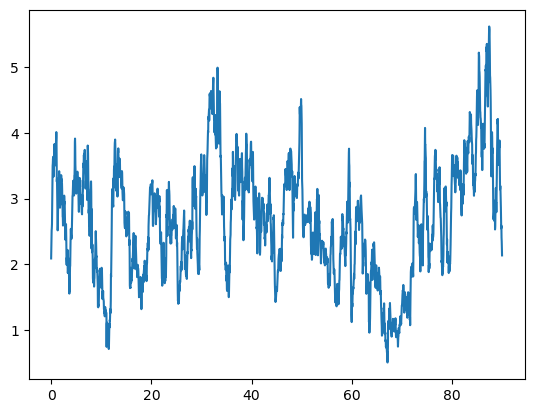

In [3]:
''' quantified stuff ''' 


pre = []
dur = []
post = []
preavg = []
duravg = []
postavg = []

arrs = []

#for i in range(1):
for i in range(infotable.shape[0]):
    #get the data
    simbarawdata = pd.read_csv(directory+infotable.name[i]+".csv", header = 0)

    behavdata = simbarawdata[["Probability_Aggression","Aggression",	
                            "Probability_Mounting",	"Mounting", 
                            "Probability_Following",	"Following",	
                            "Probability_Dominate",	"Dominate",	
                            "Probability_Social_Contact",	"Social_Contact",	
                            "Probability_Asocial",	"Asocial",	
                            "Probability_Passive",	"Passive",	
                            "Probability_Rest_Move",	"Rest_Move"]]
    
    ethoexportpath = directory+infotable.ethofile[i]+".txt"
    ethoexport = pd.read_csv(ethoexportpath, sep = ';', header = 37)#, encoding='UTF-16le') # so stupid that this works but it does #if issue with UTF-8, use 16le

    input1 = ethoexport.loc[ethoexport["Name"] == "Is input 1 High"]
    input1high = input1.loc[input1["Value"] == 1]
    input1 = input1.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input1high = input1high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])

    input2 = ethoexport.loc[ethoexport["Name"] == "Is input 2 High"]
    input2high = input2.loc[input2["Value"] == 1]
    input2 = input2.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input2high = input2high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    
    stimtimes = input2high["Recording time"].to_numpy()
    stimtimes = np.asarray(stimtimes, dtype=float)

    truncated = infotable.startf[i]
    fps = 30
    timetrunc = truncated/fps
    stimtimes = stimtimes - timetrunc
    
    stimstartidx = np.around(stimtimes*fps).astype("int")

    stimdur = infotable.stimdur[i] #in seconds
    stimidxdur = stimdur*fps
    stimendidx = stimstartidx + stimidxdur

    stim = np.zeros(behavdata[behavdata.columns[0]].shape[0])

    for j in range(stimstartidx.shape[0]):
        stim[stimstartidx[j]:stimendidx[j]] = 1
    
    BlindID = str(infotable.BlindID[i])
    MouseID = str(infotable.MouseID[i])
    Type = str(infotable.Type[i])        
    day = str(infotable.Day[i])
    trial = str(infotable.Trial[i])
    time = np.arange(0,behavdata[behavdata.columns[0]].shape[0])/fps
    avgtime = np.arange(0,stimdur*3*fps)/fps

    
    # calculate the average data
    behav = behavdata[behavdata.columns[8]].to_numpy() # 1 - aggression 9 - social contact
    window_behav = []
    for ele in stimstartidx:
            if ele > stimdur*fps and ele < (behavdata[behavdata.columns[0]].shape[0] - stimdur*fps*2):
                window_behav += [behav[ele-(stimdur*fps):ele+(stimdur*fps*2)]]
    
    window_behav = np.array(window_behav)
    avg_behav = np.average(window_behav, axis = 0)
    sum_behav = window_behav.sum(axis = 0)
    
    pre += [sum_behav[:int(sum_behav.shape[0]/3)].sum()/30]
    dur += [sum_behav[int(sum_behav.shape[0]/3):int(sum_behav.shape[0]*2/3)].sum()/30]
    post += [sum_behav[int(sum_behav.shape[0]*2/3):].sum()/30]

    preavg += [avg_behav[:int(avg_behav.shape[0]/3)].sum()/30]
    duravg += [avg_behav[int(avg_behav.shape[0]/3):int(avg_behav.shape[0]*2/3)].sum()/30]
    postavg += [avg_behav[int(avg_behav.shape[0]*2/3):].sum()/30]
    
    arrs += [avg_behav]

plt.plot(avgtime, sum_behav)

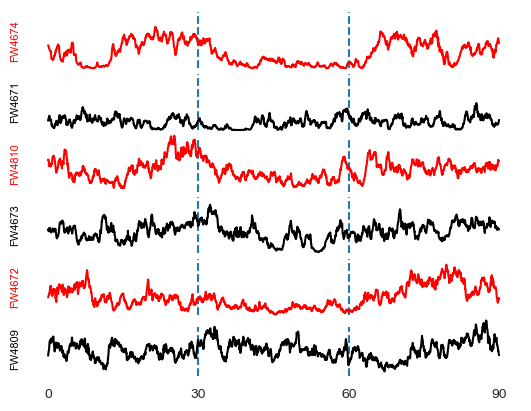

In [4]:
''' Visualize averaged traces aligned to stim, coded by type'''

sns.set_style("white")
plt.subplots_adjust(hspace=0)
for i in range(len(arrs)):
    plt.subplot(6,1,i+1)
    plt.vlines(30, 0, 0.5, linestyles = "dashed")
    plt.vlines(60, 0, 0.5, linestyles = "dashed")
    plt.yticks([])
    if infotable["Type"][i] == "Control":
        plt.plot(avgtime, arrs[i], c = 'black')
        plt.ylabel(infotable["MouseID"][i], fontsize = 8, c = "black")
               
    else:
        plt.plot(avgtime, arrs[i], c = 'red')
        plt.ylabel(infotable["MouseID"][i], fontsize = 8, c = "red")
        
plt.gca().set_xticks([0,30,60,90])
sns.despine(bottom = True, left = True)

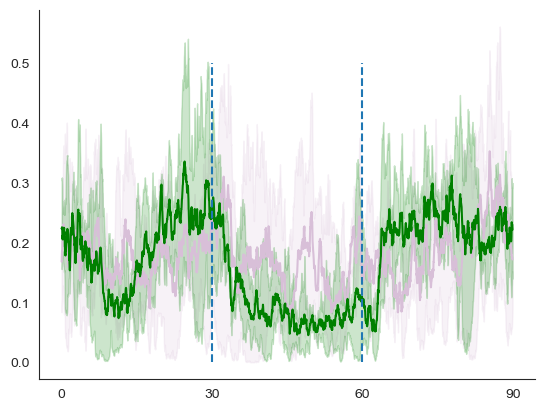

In [28]:
''' Averaged average traces '''

sns.set_style("white")
ctrl = []
chr2 = []
for i in range(len(arrs)):
    if infotable["Type"][i] == "Control":
        ctrl += [arrs[i]]  
    else:
        chr2 += [arrs[i]]


plt.plot(avgtime, np.average(ctrl, axis = 0), c = 'thistle')
plt.fill_between(avgtime, np.min(ctrl, axis = 0), np.max(ctrl, axis = 0), color = 'thistle', alpha= 0.2)
plt.plot(avgtime, np.average(chr2, axis = 0), c = 'green')
plt.fill_between(avgtime, np.min(chr2, axis = 0), np.max(chr2, axis = 0), color = 'green', alpha= 0.2)

plt.gca().set_xticks([0,30,60,90])
plt.vlines(30, 0, 0.5, linestyles = "dashed")
plt.vlines(60, 0, 0.5, linestyles = "dashed")
sns.despine()

In [29]:
ctrl

[array([0.084  , 0.0958 , 0.1004 , ..., 0.0732 , 0.0775 , 0.09115]),
 array([0.21275, 0.2117 , 0.2133 , ..., 0.22045, 0.2154 , 0.212  ]),
 array([0.20875, 0.2263 , 0.24365, ..., 0.2348 , 0.2246 , 0.2134 ])]

In [38]:
ctrls = np.average(ctrl,axis = 0)
chr2s = np.average(chr2,axis = 0)
comb = np.array([ctrls,chr2s])
comb
bframe = pd.DataFrame(comb.T, columns = ['ctrl','chr2'])
bframe.to_csv(directory+"avgavg.csv")

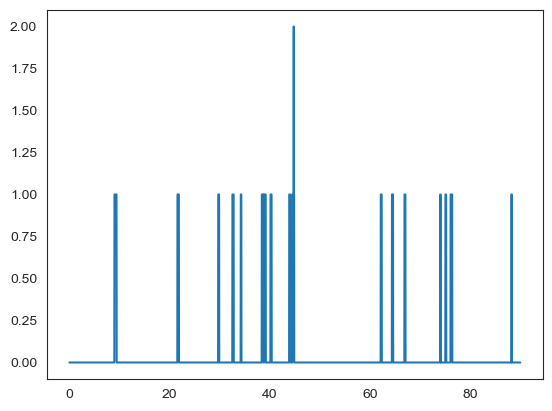

In [40]:
''' quantified stuff ''' 


pre = []
dur = []
post = []
preavg = []
duravg = []
postavg = []

arrs = []
rawarrs = []

#for i in range(1):
for i in range(infotable.shape[0]):
    #get the data
    simbarawdata = pd.read_csv(directory+infotable.name[i]+".csv", header = 0)

    behavdata = simbarawdata[["Probability_Aggression","Aggression",	
                            "Probability_Mounting",	"Mounting", 
                            "Probability_Following",	"Following",	
                            "Probability_Dominate",	"Dominate",	
                            "Probability_Social_Contact",	"Social_Contact",	
                            "Probability_Asocial",	"Asocial",	
                            "Probability_Passive",	"Passive",	
                            "Probability_Rest_Move",	"Rest_Move"]]
    
    ethoexportpath = directory+infotable.ethofile[i]+".txt"
    ethoexport = pd.read_csv(ethoexportpath, sep = ';', header = 37)#, encoding='UTF-16le') # so stupid that this works but it does #if issue with UTF-8, use 16le

    input1 = ethoexport.loc[ethoexport["Name"] == "Is input 1 High"]
    input1high = input1.loc[input1["Value"] == 1]
    input1 = input1.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input1high = input1high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])

    input2 = ethoexport.loc[ethoexport["Name"] == "Is input 2 High"]
    input2high = input2.loc[input2["Value"] == 1]
    input2 = input2.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input2high = input2high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    
    stimtimes = input2high["Recording time"].to_numpy()
    stimtimes = np.asarray(stimtimes, dtype=float)

    truncated = infotable.startf[i]
    fps = 30
    timetrunc = truncated/fps
    stimtimes = stimtimes - timetrunc
    
    stimstartidx = np.around(stimtimes*fps).astype("int")

    stimdur = infotable.stimdur[i] #in seconds
    stimidxdur = stimdur*fps
    stimendidx = stimstartidx + stimidxdur

    stim = np.zeros(behavdata[behavdata.columns[0]].shape[0])

    for j in range(stimstartidx.shape[0]):
        stim[stimstartidx[j]:stimendidx[j]] = 1
    
    BlindID = str(infotable.BlindID[i])
    MouseID = str(infotable.MouseID[i])
    Type = str(infotable.Type[i])        
    day = str(infotable.Day[i])
    trial = str(infotable.Trial[i])
    time = np.arange(0,behavdata[behavdata.columns[0]].shape[0])/fps
    avgtime = np.arange(0,stimdur*3*fps)/fps

    
    # calculate the average data
    behav = behavdata[behavdata.columns[1]].to_numpy() # 1 - aggression 9 - social contact
    window_behav = []
    for ele in stimstartidx:
            if ele > stimdur*fps and ele < (behavdata[behavdata.columns[0]].shape[0] - stimdur*fps*2):
                window_behav += [behav[ele-(stimdur*fps):ele+(stimdur*fps*2)]]
    
    rawarrs += [window_behav]
    window_behav = np.array(window_behav)
    avg_behav = np.average(window_behav, axis = 0)
    sum_behav = window_behav.sum(axis = 0)
    
    pre += [sum_behav[:int(sum_behav.shape[0]/3)].sum()/30]
    dur += [sum_behav[int(sum_behav.shape[0]/3):int(sum_behav.shape[0]*2/3)].sum()/30]
    post += [sum_behav[int(sum_behav.shape[0]*2/3):].sum()/30]

    preavg += [avg_behav[:int(avg_behav.shape[0]/3)].sum()/30]
    duravg += [avg_behav[int(avg_behav.shape[0]/3):int(avg_behav.shape[0]*2/3)].sum()/30]
    postavg += [avg_behav[int(avg_behav.shape[0]*2/3):].sum()/30]
    
    arrs += [avg_behav]
    
plt.plot(avgtime, sum_behav)

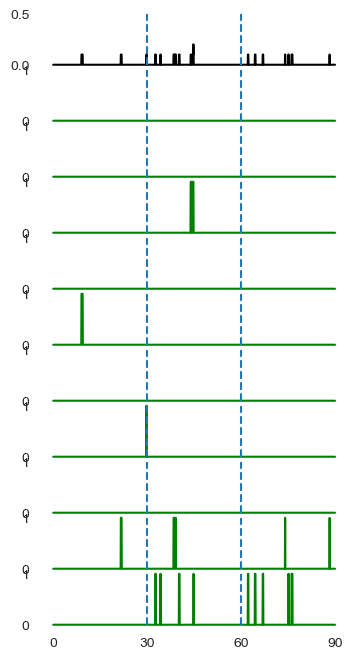

In [43]:
''' Visualize individual sweeps aligned to stim '''

n = 5
plt.subplots_adjust(hspace=0)
plt.subplot(11,1,1)
plt.plot(avgtime, np.average(rawarrs[n], axis = 0), c = 'black')
plt.vlines(30, 0, 0.5, linestyles = "dashed")
plt.vlines(60, 0, 0.5, linestyles = "dashed")

for i in range(10):
    plt.subplot(11,1,i+2)
    plt.plot(avgtime, rawarrs[n][i], c = 'green')
    plt.vlines(30, 0, 1, linestyles = "dashed")
    plt.vlines(60, 0, 1, linestyles = "dashed")

plt.gca().set_xticks([0,30,60,90])
sns.despine(bottom = True, left = True)

plt.gcf().set_size_inches(4,8)

#### Blind plot

In [5]:
''' Aggression pre-stim-post BLIND '''

markers = ["^","o", "*", "P", "p", "s", "X", "d",  "V","1"]

#markers = ["s","p","P","*","o","^"] #reversed for d2


for i, ele in enumerate(infotable["Type"].tolist()):
        #i = len(infotable["Type"].tolist()) - i -1 # for reversing day 2
        plt.plot(["Pre","Stim","Post"],[pre[i],dur[i],post[i]], color = 'r', label = infotable["BlindID"].tolist()[i], marker = markers[i], mfc = 'black', mec = 'black')
        
plt.legend(loc = (1.05,0))  
sns.despine()

plt.title("Aggression aligned to stimulation\n Day "+str(infotable['Day'][0]))
plt.ylabel("Total duration of Aggression (s)\n across stimulus bouts")
#plt.ylim(0,300)
plt.gcf().set_size_inches(4,4)





plt.savefig(directory+"rawagg.png", dpi = 600, bbox_inches = "tight")
plt.savefig(directory+"rawagg.svg", dpi = 600, bbox_inches = "tight")
plt.clf()


<Figure size 400x400 with 0 Axes>

#### Final plot

In [10]:
''' Aggression pre-stim-post FINAL '''

markers = ["^","o", "*", "P", "p", "s", "X", "d",  "V","1"]
for i, ele in enumerate(infotable["Type"].tolist()):
    if ele == 'Control': #maybe control instead?
        plt.plot(["Pre","Stim","Post"],[pre[i],dur[i],post[i]], color = 'black', label = infotable["MouseID"].tolist()[i], marker = markers[i], mfc = 'black', mec = 'black')
    else:
        plt.plot(["Pre","Stim","Post"],[pre[i],dur[i],post[i]], color = 'r', label = infotable["MouseID"].tolist()[i], marker = markers[i], mfc = 'r', mec = 'r')
        
plt.legend(loc = (1.05,0))  
sns.despine()
plt.title("Aggression aligned to stimulation\n Day "+str(infotable['Day'][0]))
plt.ylabel("Total duration of Aggression (s)\n across stimulus bouts")
#plt.ylim(0,300)
plt.gcf().set_size_inches(4,4)


plt.savefig(directory+"rawagg.png", dpi = 600, bbox_inches = "tight")
plt.savefig(directory+"rawagg.svg", dpi = 600, bbox_inches = "tight")
plt.clf()


<Figure size 400x400 with 0 Axes>

'\nplt.savefig(directory+"rawsocon.png", dpi = 600, bbox_inches = "tight")\nplt.savefig(directory+"rawsocon.svg", dpi = 600, bbox_inches = "tight")\nplt.clf()\n'

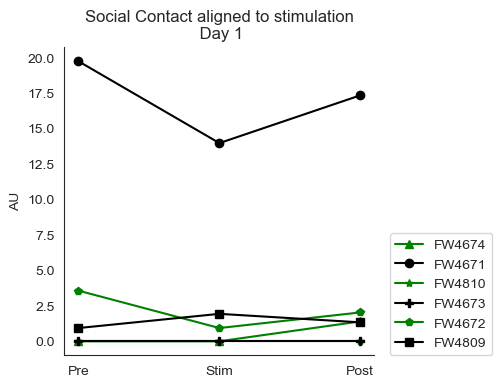

In [44]:
''' Social Contact pre-stim-post FINAL '''

markers = ["^","o", "*", "P", "p", "s", "X", "d",  "V","1"]
for i, ele in enumerate(infotable["Type"].tolist()):
    if ele == 'Control': #maybe control instead?
        plt.plot(["Pre","Stim","Post"],[pre[i],dur[i],post[i]], color = 'black', label = infotable["MouseID"].tolist()[i], marker = markers[i], mfc = 'black', mec = 'black')
    else:
        plt.plot(["Pre","Stim","Post"],[pre[i],dur[i],post[i]], color = 'g', label = infotable["MouseID"].tolist()[i], marker = markers[i], mfc = 'g', mec = 'g')
        
plt.legend(loc = (1.05,0))  
sns.despine()
plt.title("Social Contact aligned to stimulation\n Day "+str(infotable['Day'][0]))
plt.ylabel("AU")
#plt.ylim(0,300)
plt.gcf().set_size_inches(4,4)

'''
plt.savefig(directory+"rawsocon.png", dpi = 600, bbox_inches = "tight")
plt.savefig(directory+"rawsocon.svg", dpi = 600, bbox_inches = "tight")
plt.clf()
'''

In [81]:
stats.ttest_ind(precontrol,preexp)

TtestResult(statistic=-1.1798155582885834, pvalue=0.3034481668172573, df=4.0)

In [82]:
stats.ttest_ind(stimcontrol,stimexp)

TtestResult(statistic=0.08194794516976925, pvalue=0.9386248770994348, df=4.0)

In [83]:
stats.ttest_ind(postcontrol,postexp)

TtestResult(statistic=-0.48602099687127337, pvalue=0.6523766005280223, df=4.0)

(0.0, 12.327777777777778)

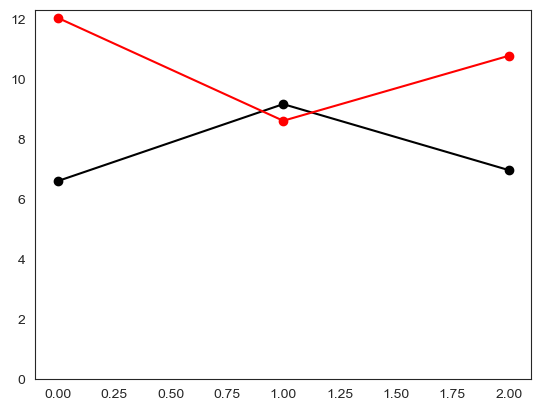

In [85]:
plt.plot([0,1,2],[np.average(precontrol), np.average(stimcontrol), np.average(postcontrol)], color = 'black')
plt.scatter([0,1,2],[np.average(precontrol), np.average(stimcontrol), np.average(postcontrol)], color = 'black')
plt.plot([0,1,2],[np.average(preexp), np.average(stimexp), np.average(postexp)], color = 'red')
plt.scatter([0,1,2],[np.average(preexp), np.average(stimexp), np.average(postexp)], color = 'red')
plt.ylim(0,)

Text(1.5, 1.3, 'p = 0.546')

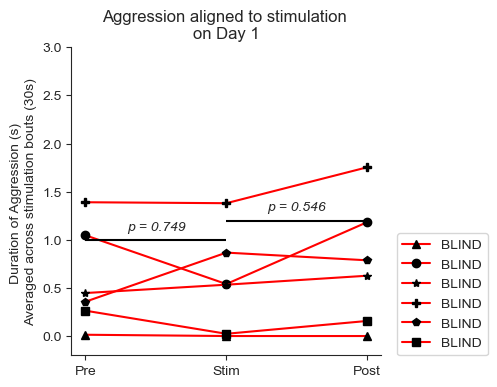

In [12]:
''' Averaged across stim blocks '''

markers = ["^","o", "*", "P", "p", "s", "X", "d",  "V","1"]
for i, ele in enumerate(infotable["Type"].tolist()):
    if ele == 'GFP': #maybe control instead?
        plt.plot(["Pre","Stim","Post"],[preavg[i],duravg[i],postavg[i]], color = 'black', label = infotable["MouseID"].tolist()[i], marker = markers[i], mfc = 'black', mec = 'black')
    else:
        plt.plot(["Pre","Stim","Post"],[preavg[i],duravg[i],postavg[i]], color = 'r', label = infotable["MouseID"].tolist()[i], marker = markers[i], mfc = 'black', mec = 'black')
plt.legend(loc = (1.05,0))  
sns.despine()
plt.gca().tick_params(axis='y', left=True)
plt.gca().tick_params(axis='x', bottom=True)
plt.title("Aggression aligned to stimulation \non Day "+str(infotable['Day'][0]))
plt.ylabel("Duration of Aggression (s) \nAveraged across stimulation bouts (30s)")
plt.gcf().set_size_inches(4,4)
plt.ylim(-0.2,3)

plt.hlines(1,0,1, color = 'black')
plt.text(0.5,1.1,"p = 0.749", horizontalalignment = 'center', style = 'italic')


plt.hlines(1.2,1,2, color = 'black')
plt.text(1.5,1.3,"p = 0.546", horizontalalignment = 'center', style = 'italic')


#plt.savefig(directory+"avgagg.png", dpi = 600, bbox_inches = "tight")
#plt.savefig(directory+"avgagg.svg", dpi = 600, bbox_inches = "tight")


In [13]:
print(stats.shapiro(preavg))
print(stats.shapiro(duravg))
print(stats.shapiro(postavg))

ShapiroResult(statistic=0.9090417623519897, pvalue=0.4301225543022156)
ShapiroResult(statistic=0.9237877130508423, pvalue=0.5330504179000854)
ShapiroResult(statistic=0.9616021513938904, pvalue=0.831999659538269)


In [14]:
stats.ttest_rel(preavg,duravg)

TtestResult(statistic=0.20827209779242234, pvalue=0.8432346900916551, df=5)

In [15]:
stats.ttest_rel(duravg,postavg)

TtestResult(statistic=-1.7685139677984707, pvalue=0.13721002083156683, df=5)

## Plot velocity traces

In [55]:
i = 5
#for i in range(infotable.shape[0]):
    #get the data
simbarawdata = pd.read_csv(directory+infotable.name[i]+".csv", header = 0)

behavdata = simbarawdata[["Probability_Aggression","Aggression",	
                            "Probability_Mounting",	"Mounting", 
                            "Probability_Following",	"Following",	
                            "Probability_Dominate",	"Dominate",	
                            "Probability_Social_Contact",	"Social_Contact",	
                            "Probability_Asocial",	"Asocial",	
                            "Probability_Passive",	"Passive",	
                            "Probability_Rest_Move",	"Rest_Move"]]
    
ethoexportpath = directory+infotable.ethofile[i]+".txt"
ethoexport = pd.read_csv(ethoexportpath, sep = ';', header = 37)#, encoding='UTF-16le') # so stupid that this works but it does #if issue with UTF-8, use 16le

input1 = ethoexport.loc[ethoexport["Name"] == "Is input 1 High"]
input1high = input1.loc[input1["Value"] == 1]
input1 = input1.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
input1high = input1high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])

input2 = ethoexport.loc[ethoexport["Name"] == "Is input 2 High"]
input2high = input2.loc[input2["Value"] == 1]
input2 = input2.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
input2high = input2high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    
stimtimes = input2high["Recording time"].to_numpy()
stimtimes = np.asarray(stimtimes, dtype=float)

truncated = infotable.startf[i]
fps = 30
timetrunc = truncated/fps
stimtimes = stimtimes - timetrunc
    
stimstartidx = np.around(stimtimes*fps).astype("int")

stimdur = infotable.stimdur[i] #in seconds
stimidxdur = stimdur*fps
stimendidx = stimstartidx + stimidxdur

stim = np.zeros(behavdata[behavdata.columns[0]].shape[0])

for j in range(stimstartidx.shape[0]):
        stim[stimstartidx[j]:stimendidx[j]] = 1
    
BlindID = str(infotable.BlindID[i])
MouseID = str(infotable.MouseID[i])
Type = str(infotable.Type[i])        
day = str(infotable.Day[i])
trial = str(infotable.Trial[i])
time = np.arange(0,behavdata[behavdata.columns[0]].shape[0])/fps
avgtime = np.arange(0,stimdur*3*fps)/fps

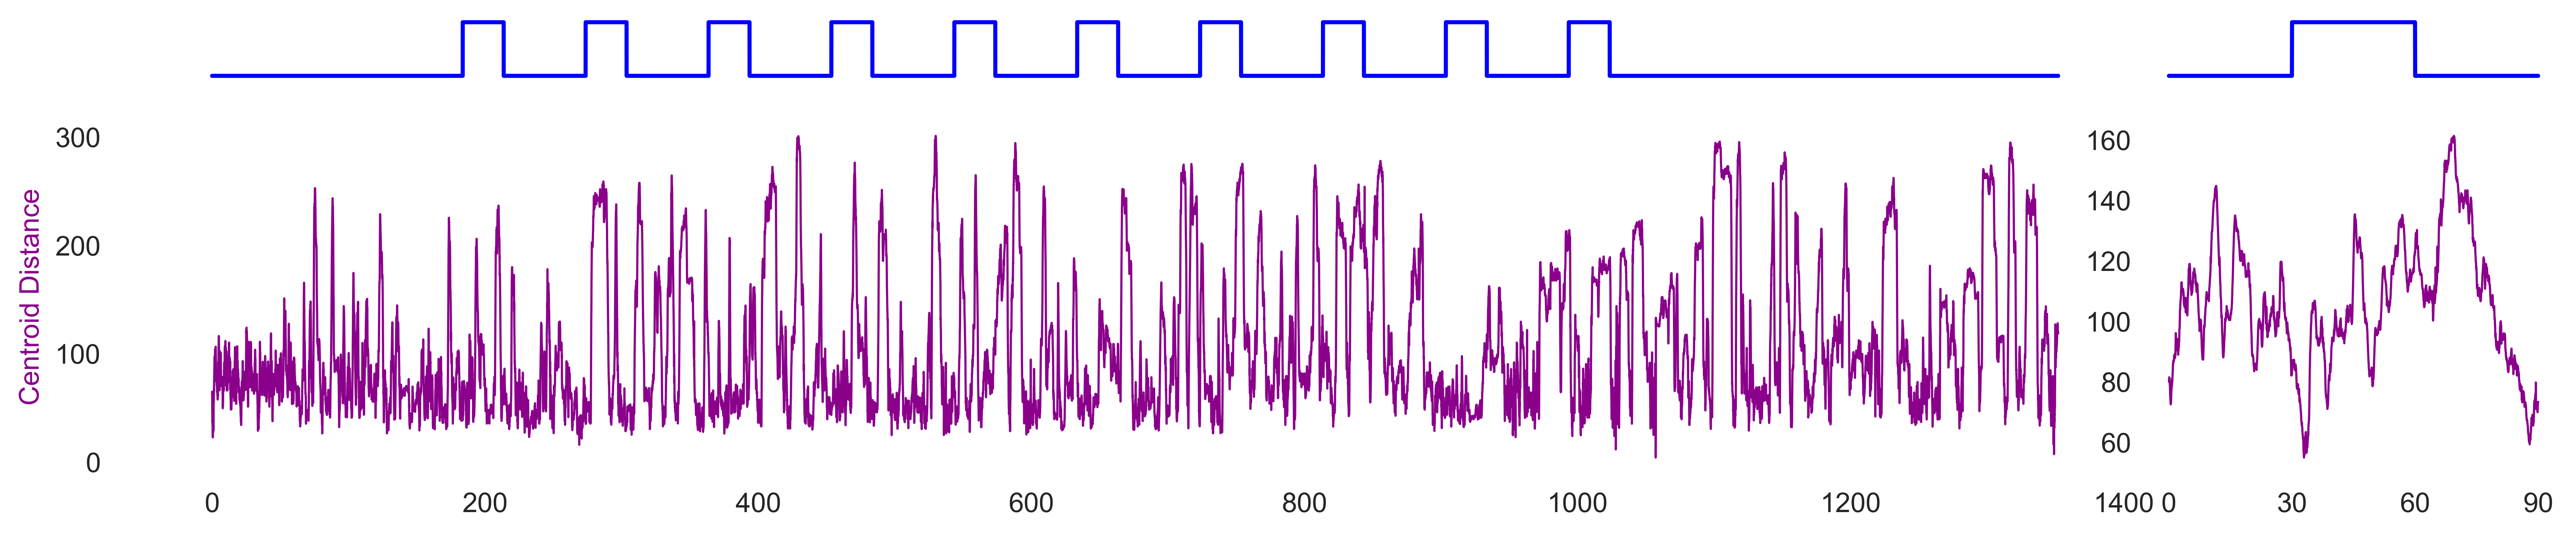

In [56]:
sns.set_style("white")

behav = simbarawdata['Centroid_distance'][1:].to_numpy() #data to plot

plt.subplots(2,2,gridspec_kw={'height_ratios': [1,6],'width_ratios': [5,1]}) #15,1
plt.subplots_adjust(wspace=0)

plt.subplot(2,2,1)
plt.plot(time,stim, color = 'blue')
plt.yticks([])
plt.xticks([])

plt.subplot(2,2,2)
plt.plot(avgtime,stim[stimstartidx[0]-(stimdur*fps):stimstartidx[0]+(stimdur*fps*2)], color = 'blue')
plt.gca().set_xticks([]) 
plt.gca().set_yticks([])

plt.subplot(2,2,3)
plt.plot(time[1:], behav, color = "darkmagenta", linewidth = 0.8)
plt.ylabel("Centroid Distance",color = "darkmagenta")
#plt.ylim(0,42)

plt.subplot(2,2,4)


window_behav = []
for ele in stimstartidx:
    window_behav += [behav[ele-(stimdur*fps):ele+(stimdur*fps*2)]]
window_behav = np.array(window_behav)
avg_behav = np.average(window_behav, axis = 0)
    
# plot the average data
plt.plot(avgtime,avg_behav, color = "darkmagenta", linewidth = 0.8)
plt.gca().set_xticks([0,30,60,90])
#plt.ylim(bottom = 0)
#plt.ylim(0,10)
sns.despine(left = True, bottom = True)
mpl.rcParams['figure.dpi'] = 600 #set dpi for viewing figs within the notebook
plt.gcf().set_size_inches(16,3)

In [19]:
pres = []
stims = []
posts = []
for ele in window_behav:
    pres += [np.average(ele[:stimdur*fps])]
    stims += [np.average(ele[stimdur*fps:stimdur*fps*2])]
    posts += [np.average(ele[stimdur*fps*2:])]

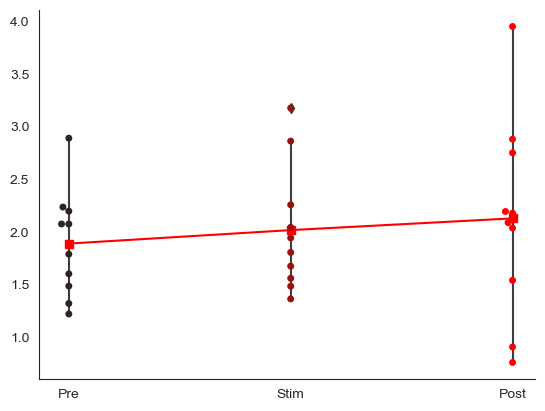

In [20]:
sns.boxplot([pres,stims,posts], width = 0)
sns.swarmplot([pres, stims, posts], palette = "dark:red")
plt.plot([np.average(pres),np.average(stims),np.average(posts)], marker = 's', color = 'r')
plt.xticks([0,1,2], labels = ["Pre","Stim","Post"])
sns.despine()

Text(0.5, 0.98, 'X and Y')

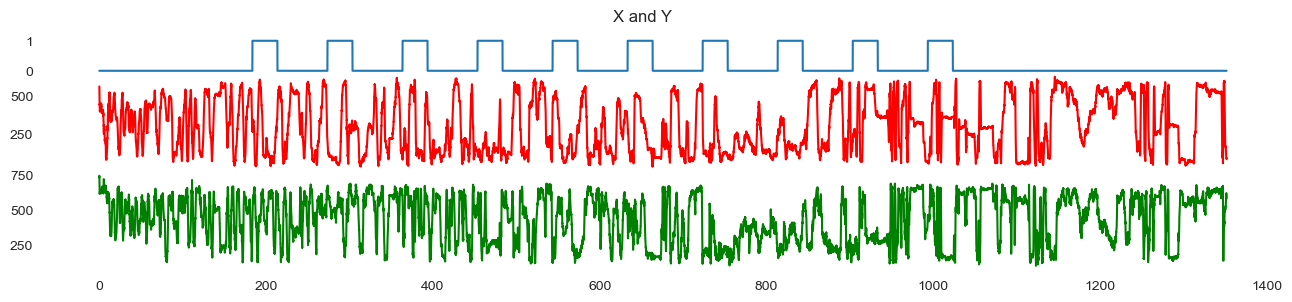

In [15]:
sns.set_style("white")

plt.subplots(3,1,gridspec_kw={'height_ratios': [1,3,3]}) #15,1
plt.subplots_adjust(hspace=0)
#

plt.subplot(3,1,1)
plt.plot(time,stim)

plt.subplot(3,1,2)
plt.plot(time[1:],simbarawdata['Center_1_x'][1:], color = 'r')

plt.subplot(3,1,3)
plt.plot(time[1:],simbarawdata['Center_1_y'][1:]*2, color = 'g')

sns.despine(left = True, bottom = True)
plt.gcf().set_size_inches(16,3)
plt.suptitle("X and Y")

Text(0.5, 0.98, 'Tail base movement')

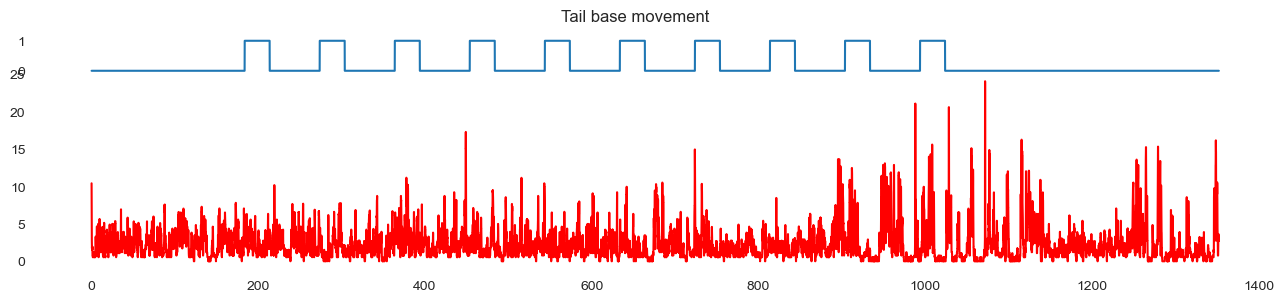

In [16]:
sns.set_style("white")

plt.subplots(2,1,gridspec_kw={'height_ratios': [1,6]}) #15,1
plt.subplots_adjust(hspace=0)
#

plt.subplot(2,1,1)
plt.plot(time,stim)
plt.subplot(2,1,2)
plt.plot(time[10:],simbarawdata['Tail_base_movement_M1_median_2'][10:], color = 'r')

sns.despine(left = True, bottom = True)
plt.gcf().set_size_inches(16,3)
plt.suptitle("Tail base movement")

Text(0.16, 0.95, 'BLIND Resident BLIND : Day 1 Trial 3')

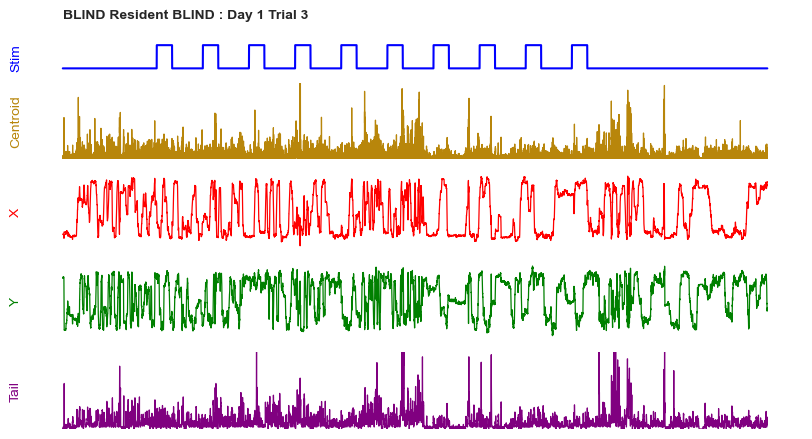

In [23]:
sns.set_style("white")

plt.subplots(5,1,gridspec_kw={'height_ratios': [1,3,3,3,3]}) #15,1
#plt.subplots_adjust(hspace=0)

plt.subplot(5,1,1)
plt.plot(time[10:],stim[10:], color = "blue")
plt.yticks([])
plt.xticks([])
plt.ylabel("Stim", color = 'blue')

plt.subplot(5,1,2)
plt.plot(time[10:],simbarawdata['Movement_mouse_1_centroid'][10:]*2, color = 'darkgoldenrod', linewidth = 0.9)
plt.ylim(0,75)
plt.yticks([])
plt.xticks([])
plt.ylabel("Centroid", color = 'darkgoldenrod')

plt.subplot(5,1,3)
plt.plot(time[10:],simbarawdata['Center_1_x'][10:], color = 'red', linewidth = 0.9)
plt.yticks([])
plt.xticks([])
plt.ylabel("X", color = 'red')

plt.subplot(5,1,4)
plt.plot(time[10:],simbarawdata['Center_1_y'][10:], color = 'green', linewidth = 0.9)
plt.yticks([])
plt.xticks([])
plt.ylabel("Y", color = 'green')

plt.subplot(5,1,5)
plt.plot(time[10:],simbarawdata['Tail_base_movement_M1_median_2'][10:]*2, color = 'purple', linewidth = 0.9)
plt.ylim(0,40)
plt.yticks([])
plt.xticks([])
plt.ylabel("Tail", color = 'purple')

sns.despine(left = True, bottom = True)
plt.gcf().set_size_inches(10,5)
plt.gcf().suptitle(Type+" Resident "+MouseID+" : Day "+day+" Trial "+trial, ha = 'left', x = 0.16, y = 0.95, fontsize = 10, fontweight = "bold")

In [ ]:
''' VMHvl Effect Plotter ''' 

# for i in range(1):
for i in range(infotable.shape[0]):
    #get the data
    simbarawdata = pd.read_csv(directory+infotable.name[i]+".csv", header = 0)

    behavdata = simbarawdata[["Probability_Aggression","Aggression",	
                            "Probability_Mounting",	"Mounting", 
                            "Probability_Following",	"Following",	
                            "Probability_Dominate",	"Dominate",	
                            "Probability_Social_Contact",	"Social_Contact",	
                            "Probability_Asocial",	"Asocial",	
                            "Probability_Passive",	"Passive",	
                            "Probability_Rest_Move",	"Rest_Move"]]
    
    ethoexportpath = directory+infotable.ethofile[i]+".txt"
    ethoexport = pd.read_csv(ethoexportpath, sep = ';', header = 37)#, encoding='UTF-16le') # so stupid that this works but it does #if issue with UTF-8, use 16le

    input1 = ethoexport.loc[ethoexport["Name"] == "Is input 1 High"]
    input1high = input1.loc[input1["Value"] == 1]
    input1 = input1.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input1high = input1high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])

    input2 = ethoexport.loc[ethoexport["Name"] == "Is input 2 High"]
    input2high = input2.loc[input2["Value"] == 1]
    input2 = input2.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input2high = input2high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    
    stimtimes = input2high["Recording time"].to_numpy()
    stimtimes = np.asarray(stimtimes, dtype=float)

    truncated = infotable.startf[i]
    fps = 30
    timetrunc = truncated/fps
    stimtimes = stimtimes - timetrunc
    
    stimstartidx = np.around(stimtimes*fps).astype("int")

    stimdur = infotable.stimdur[i] #in seconds
    stimidxdur = stimdur*fps
    stimendidx = stimstartidx + stimidxdur

    stim = np.zeros(behavdata[behavdata.columns[0]].shape[0])

    for j in range(stimstartidx.shape[0]):
        stim[stimstartidx[j]:stimendidx[j]] = 1
    
    BlindID = str(infotable.BlindID[i])
    MouseID = str(infotable.MouseID[i])
    Type = str(infotable.Type[i])        
    day = str(infotable.Day[i])
    trial = str(infotable.Trial[i])
    time = np.arange(0,behavdata[behavdata.columns[0]].shape[0])/fps
    avgtime = np.arange(0,stimdur*3*fps)/fps

    sns.set_style("white")

    plt.subplots(5,1,gridspec_kw={'height_ratios': [1,3,3,3,3]}) #15,1
    #plt.subplots_adjust(hspace=0)
    
    plt.subplot(5,1,1)
    plt.plot(time[10:],stim[10:], color = "blue")
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("Stim", color = 'blue')
    
    plt.subplot(5,1,2)
    plt.plot(time[10:],simbarawdata['Center_1_x'][10:], color = 'red', linewidth = 0.9)
    plt.yticks([])
    plt.ylabel("X", color = 'red')
    
    plt.subplot(5,1,3)
    plt.plot(time[10:],simbarawdata['Center_1_y'][10:], color = 'green', linewidth = 0.9)
    plt.yticks([])
    plt.ylabel("Y", color = 'green')
    
    plt.subplot(5,1,4)
    plt.plot(time[10:],simbarawdata['Movement_mouse_1_centroid'][10:]*2, color = 'darkgoldenrod', linewidth = 0.9)
    plt.ylim(0,75)
    plt.yticks([])
    plt.ylabel("Centroid", color = 'darkgoldenrod')
    
    plt.subplot(5,1,5)
    plt.plot(time[10:],simbarawdata['Tail_base_movement_M1_median_2'][10:]*2, color = 'purple', linewidth = 0.9)
    plt.ylim(0,40)
    plt.yticks([])
    plt.ylabel("Tail", color = 'purple')
    
    sns.despine(left = True, bottom = True)
    plt.gcf().set_size_inches(10,5)
    plt.gcf().suptitle(Type+" Resident "+MouseID+" : Day "+day+" Trial "+trial, ha = 'left', x = 0.16, y = 0.95, fontsize = 10, fontweight = "bold")
    
    plt.savefig(directory+"Movement_"+MouseID+".svg", dpi = 600, bbox_inches = "tight")
    plt.savefig(directory+"Movement_"+MouseID+".png", dpi = 600, bbox_inches = "tight")
    plt.clf()        

In [182]:
''' VMHvl Effect Plotter ''' 

# for i in range(1):
for i in range(infotable.shape[0]):
    #get the data
    simbarawdata = pd.read_csv(directory+infotable.name[i]+".csv", header = 0)

    behavdata = simbarawdata[["Probability_Aggression","Aggression",	
                            "Probability_Mounting",	"Mounting", 
                            "Probability_Following",	"Following",	
                            "Probability_Dominate",	"Dominate",	
                            "Probability_Social_Contact",	"Social_Contact",	
                            "Probability_Asocial",	"Asocial",	
                            "Probability_Passive",	"Passive",	
                            "Probability_Rest_Move",	"Rest_Move"]]
    
    ethoexportpath = directory+infotable.ethofile[i]+".txt"
    ethoexport = pd.read_csv(ethoexportpath, sep = ';', header = 37)#, encoding='UTF-16le') # so stupid that this works but it does #if issue with UTF-8, use 16le

    input1 = ethoexport.loc[ethoexport["Name"] == "Is input 1 High"]
    input1high = input1.loc[input1["Value"] == 1]
    input1 = input1.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input1high = input1high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])

    input2 = ethoexport.loc[ethoexport["Name"] == "Is input 2 High"]
    input2high = input2.loc[input2["Value"] == 1]
    input2 = input2.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    input2high = input2high.drop(columns = ['Trial time', 'Device', 'Command/Signal', 'Unnamed: 6'])
    
    stimtimes = input2high["Recording time"].to_numpy()
    stimtimes = np.asarray(stimtimes, dtype=float)

    truncated = infotable.startf[i]
    fps = 30
    timetrunc = truncated/fps
    stimtimes = stimtimes - timetrunc
    
    stimstartidx = np.around(stimtimes*fps).astype("int")

    stimdur = infotable.stimdur[i] #in seconds
    stimidxdur = stimdur*fps
    stimendidx = stimstartidx + stimidxdur

    stim = np.zeros(behavdata[behavdata.columns[0]].shape[0])

    for j in range(stimstartidx.shape[0]):
        stim[stimstartidx[j]:stimendidx[j]] = 1
    
    BlindID = str(infotable.BlindID[i])
    MouseID = str(infotable.MouseID[i])
    Type = str(infotable.Type[i])        
    day = str(infotable.Day[i])
    trial = str(infotable.Trial[i])
    time = np.arange(0,behavdata[behavdata.columns[0]].shape[0])/fps
    avgtime = np.arange(0,stimdur*3*fps)/fps

    sns.set_style("white")

    plt.subplots(2,2,gridspec_kw={'height_ratios': [1,6],'width_ratios': [5,1]}) #15,1
    plt.subplots_adjust(wspace=0)

    plt.subplot(2,2,1)
    plt.plot(time[1:],stim[1:], color = 'blue')
    plt.yticks([])
    plt.xticks([])

    plt.subplot(2,2,2)
    avgstim = np.zeros(stimdur*3*fps)
    avgstim[stimdur*fps:stimdur*fps*2] = 1
    plt.plot(avgtime, avgstim, color = 'blue')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])

    plt.subplot(2,2,3)
    plt.plot(time[1:],simbarawdata['Movement_mouse_1_centroid'][1:], color = "darkmagenta", linewidth = 0.8)
    plt.ylabel("Centroid Movement",color = "darkmagenta")
    plt.ylim(0,42)

    plt.subplot(2,2,4)

    behav = simbarawdata['Movement_mouse_1_centroid'][1:].to_numpy()
    window_behav = []
    for ele in stimstartidx:
        if ele > stimdur*fps and ele < (behavdata[behavdata.columns[0]].shape[0] - stimdur*fps*2):
            window_behav += [behav[ele-(stimdur*fps):ele+(stimdur*fps*2)]]
    window_behav = np.array(window_behav)
    avg_behav = np.average(window_behav, axis = 0)
    
    # plot the average data
    plt.plot(avgtime,avg_behav, color = "darkmagenta", linewidth = 0.8)
    #plt.gca().set_xticks([0,30,60,90])
    plt.gca().set_xticks([0,10,20,30])
    #plt.ylim(bottom = 0)
    plt.ylim(0,10)
    sns.despine(left = True, bottom = True)

    plt.gcf().set_size_inches(16,3)    
    plt.gcf().suptitle(Type+" Resident "+MouseID+" : Day "+day+" Trial "+trial, ha = 'left', x = 0.16, y = 0.95, fontsize = 10, fontweight = "bold")
    
    plt.savefig(directory+"Movement_"+MouseID+".svg", dpi = 600, bbox_inches = "tight")
    plt.savefig(directory+"Movement_"+MouseID+".png", dpi = 600, bbox_inches = "tight")
    plt.clf()

<Figure size 1600x300 with 0 Axes>

<Figure size 1600x300 with 0 Axes>

<Figure size 1600x300 with 0 Axes>

<Figure size 1600x300 with 0 Axes>

<Figure size 1600x300 with 0 Axes>

<Figure size 1600x300 with 0 Axes>